<a href="https://colab.research.google.com/github/Belal-AI/FSDAwaesf/blob/main/U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torch.nn.functional import relu
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torchvision.transforms import Compose,Resize,ToTensor,Normalize

In [68]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [69]:
sample=list(dataset['train'])[0]['image']

sample.shape

TensorShape([500, 500, 3])

In [128]:
def to_torch_tensor(imge):
  """
  function used to to get the sample frome the iterator
  and convert to tensor torch
  """
  img=imge['image']

  mask=imge['segmentation_mask']
  mean = np.mean(img.numpy())

  image = torch.tensor(img.numpy())
  mask = torch.tensor(mask.numpy())

  return image , mask


In [129]:
img_list=[]
mask_list=[]
c=0
"""
itertat on the sampel and pass it speratly
"""
for i in list(dataset['train']):
  if c!=200:
    img,mask=to_torch_tensor(i)
    img_list.append(img)
    mask_list.append(mask)
  else:
    break
  c+=1


In [130]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        desired_output_size = 125
# Calculate the padding needed to achieve the desired output size
        padding_needed = max(0, desired_output_size - 250)

# Determine padding size for each side
        padding_left = padding_needed // 2
        padding_right = padding_needed - padding_left

# Define the ConvTranspose2d layer with the adjusted padding

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=1, stride=2,padding=padding_needed)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)
    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        print(xe12.shape)
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        print(xe22.shape)
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))


        #decoder
        u1=relu(self.upconv1(xe52))
        catu1=torch.concat([u1,xe42],dim=1)
        u1c1=relu(self.d11(catu1))
        u1c2=relu(self.d12(u1c1))

        u2=relu(self.upconv2(u1c2))
        u2 = F.interpolate(u2, size=(125, 125), mode='bilinear', align_corners=False)
        catu2=torch.concat([u2,xe32],dim=1)
        u2c1=relu(self.d21(catu2))
        u2c2=relu(self.d22(u2c1))



        u3=relu(self.upconv3(u2c2))
        concat3=torch.concat([u3,xe22],dim=1)
        u3c1=relu(self.d31(concat3))
        u3c2=relu(self.d32(u3c1))


        u4=relu(self.upconv4(u3c2))
        concat4=torch.concat([u4,xe12],dim=1)
        u4c1=relu(self.d41(concat4))
        u4c2=relu(self.d42(u4c1))
        print(u4c2.shape)
        cls=F.softmax(self.outconv(u4c2),dim=1)

        return cls


In [131]:
first=UNet(3)

In [132]:
cls_victors=first.forward(torch.unsqueeze(img_list[0].float(),0).permute(0,3,1,2))

torch.Size([1, 64, 500, 500])
torch.Size([1, 128, 250, 250])
torch.Size([1, 64, 500, 500])


In [133]:
_, predicted_labels = torch.max(cls_victors, dim=1)

In [134]:
torch.unique(predicted_labels)

tensor([0, 2])

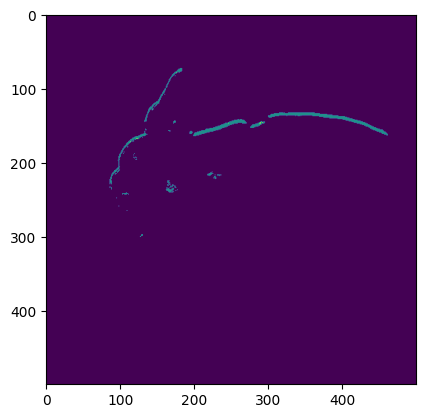

In [101]:
plt.imshow(predicted_labels.squeeze().cpu().numpy(), cmap='viridis')  # Squeeze removes the singleton dimension

In [146]:
optmizer=torch.optim.AdamW(first.parameters())

In [104]:
predicted_labels.shape

torch.Size([1, 500, 500])

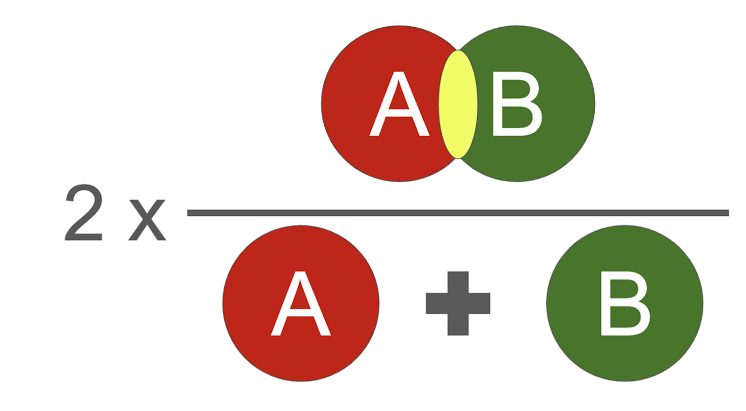

In [151]:
import torch

def dice_loss(predicted, target, smooth=1.):

    """
    one of the most important metrics that calculate the similarity between objects
    by flatten it and pass it to get the intersection from it and devide it on the
    summations
    """
    predicted_flat = predicted.view(-1)
    target_flat = target.view(-1)

    intersection = (predicted_flat * target_flat).sum()
    dice_coeff = (2. * intersection + smooth) / (predicted_flat.sum() + target_flat.sum() + smooth)
    return 1. - dice_coeff




In [150]:
"""
a cycle for the training just one epch
"""
losses = []
optmizer.zero_grad()
ypred = predicted_labels.float()  # Convert to float if not already
gt_mask = mask_list[0].permute(2, 0, 1).float()  # Convert to float if not already
loss = dice_loss(ypred, gt_mask)
losses.append(loss.item())  # Append loss value to the list
loss.requires_grad = True
loss.backward()
optmizer.step()


torch.Size([250000])
